In [1]:
import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials
import matplotlib.pyplot as mpl
from matplotlib import pyplot as plt
import scipy.cluster.hierarchy as sch,random,numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster import hierarchy



assets = ['IVV','VBTLX', 'EEM', 'TLT','HYG']

yahoo_financials = YahooFinancials(assets)

data = yahoo_financials.get_historical_price_data(start_date='2015-01-01', 
                                                  end_date='2022-02-01', 
                                                  time_interval='daily')

prices_df = pd.DataFrame({
    a: {x['formatted_date']: x['adjclose'] for x in data[a]['prices']} for a in assets
})

In [2]:
daily_returns = prices_df.pct_change()
daily_returns.tail()

,IVV,VBTLX,EEM,TLT,HYG
2022-01-25,-0.011506,-0.000912,-0.001863,-0.001615,-0.002929
2022-01-26,-0.002314,-0.005474,-0.012650,-0.012094,-0.003408
2022-01-27,-0.005213,0.002752,-0.011552,0.018363,-0.004363
2022-01-28,0.024448,0.000915,0.004887,0.000349,0.002842
2022-01-31,0.018073,0.000733,0.032776,-0.005170,0.000236


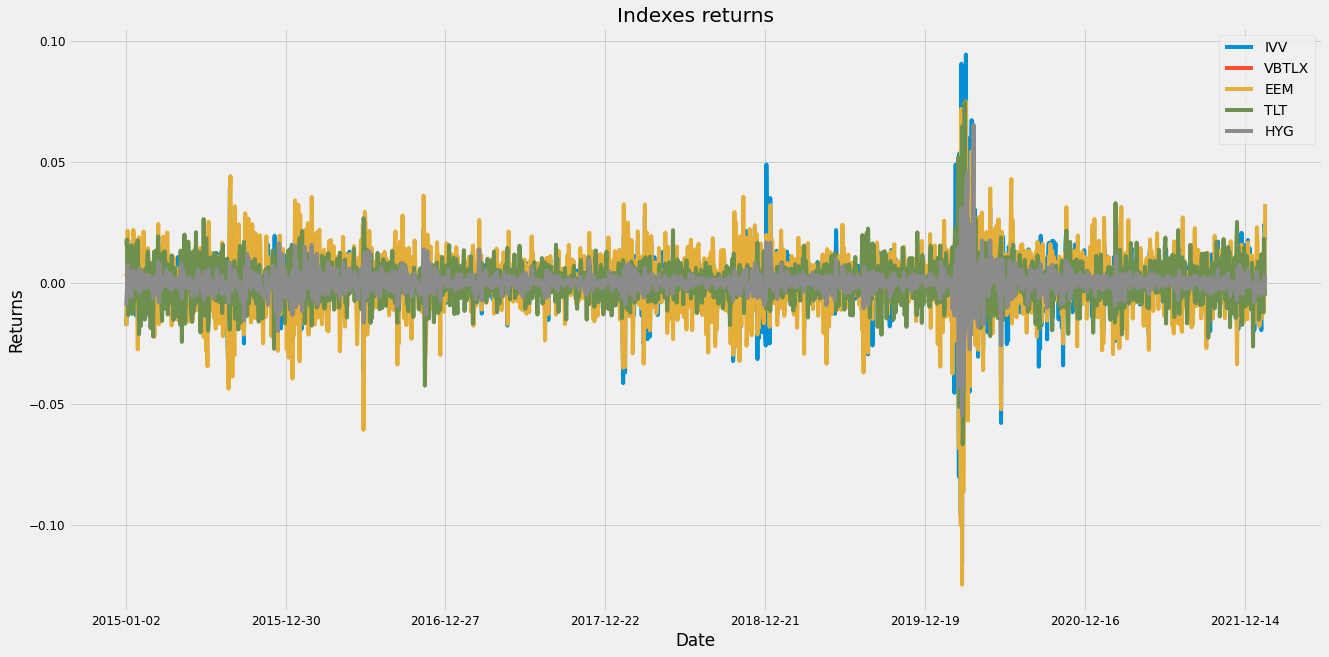

In [3]:
def plot_data(df, title="Indexes returns"):
    """Plot stock prices with a custom title and meaningful axis labels."""
    ax = df.plot(title=title, fontsize=12)
    ax.set_xlabel("Date")
    ax.set_ylabel("Returns")
    plt.show()
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20, 10)

plot = plot_data(daily_returns)


In [4]:
cov,corr=daily_returns.cov(),daily_returns.corr()


In [5]:
corr.style.background_gradient(cmap='coolwarm')

,IVV,VBTLX,EEM,TLT,HYG
IVV,1.000000,-0.251323,0.786049,-0.376072,0.772882
VBTLX,-0.251323,1.000000,-0.162077,0.887620,-0.051149
EEM,0.786049,-0.162077,1.000000,-0.277754,0.677254
TLT,-0.376072,0.887620,-0.277754,1.000000,-0.236839
HYG,0.772882,-0.051149,0.677254,-0.236839,1.000000


In [6]:
cov

,IVV,VBTLX,EEM,TLT,HYG
IVV,0.000128,-6.736843e-06,0.000121,-0.000038,4.609429e-05
VBTLX,-0.000007,5.598891e-06,-0.000005,0.000019,-6.371663e-07
EEM,0.000121,-5.195103e-06,0.000184,-0.000033,4.829859e-05
TLT,-0.000038,1.868013e-05,-0.000033,0.000079,-1.108963e-05
HYG,0.000046,-6.371663e-07,0.000048,-0.000011,2.771551e-05


In [40]:
def getIVP(cov, **kargs):
    # Compute the inverse-variance portfolio
    ivp=1./np.diag(cov)
    ivp/=ivp.sum()
    return ivp

In [41]:
ivp = getIVP(cov)

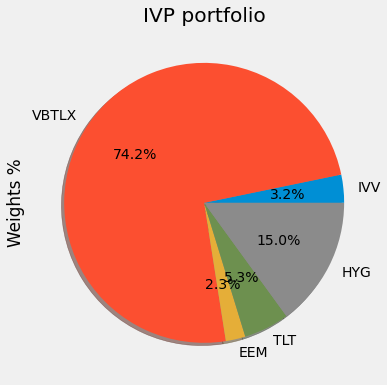

In [42]:
w = np.around(ivp*100, decimals=2)
w_ivp = pd.DataFrame(data = w)
w_ivp.columns =['Weights %']
w_ivp.index = assets
plot = w_ivp.plot.pie(y='Weights %', title="IVP portfolio", legend=False, autopct='%1.1f%%', 
                   shadow=True, startangle=0, figsize=(6, 6))

In [24]:
def correlDist(corr):
    # A distance matrix based on correlation, where 0<=d[i,j]<=1
    # This is a proper distance metric
    dist = ((1 - corr) / 2.)**.5  # distance matrix
    return dist

In [25]:
dist = correlDist(corr)

In [33]:
dist

,IVV,VBTLX,EEM,TLT,HYG
IVV,0.000000,0.790988,0.327071,0.829479,0.336985
VBTLX,0.790988,0.000000,0.762259,0.237044,0.724965
EEM,0.327071,0.762259,0.000000,0.799298,0.401713
TLT,0.829479,0.237044,0.799298,0.000000,0.786397
HYG,0.336985,0.724965,0.401713,0.786397,0.000000


In [26]:
link = linkage(dist,'single')

<ipython-input-26-9619c5d8bddf>:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = linkage(dist,'single')


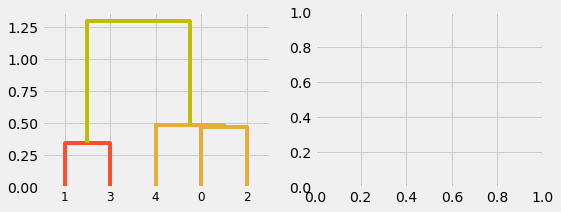

In [32]:
Z = pd.DataFrame(link)

fig, axes = plt.subplots(1, 2, figsize=(8, 3))
dn1 = hierarchy.dendrogram(Z, ax=axes[0], above_threshold_color='y', orientation='top')
plt.show()

In [27]:
def getQuasiDiag(link):
    # Sort clustered items by distance
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3]  # number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0] * 2, 2)  # make space
        df0 = sortIx[sortIx >= numItems]  # find clusters
        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        sortIx = sortIx.append(df0)  # item 2
        sortIx = sortIx.sort_index()  # re-sort
        sortIx.index = range(sortIx.shape[0])  # re-index
    return sortIx.tolist()

In [28]:
sortIx = getQuasiDiag(link)
sortIx
sortIx = corr.index[sortIx].tolist()

In [29]:
def getClusterVar(cov,cItems):
    # Compute variance per cluster
    cov_=cov.loc[cItems,cItems] # matrix slice
    w_=getIVP(cov_).reshape(-1,1)
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar

def getRecBipart(cov, sortIx):
    # Compute HRP alloc
    w = pd.Series(1, index=sortIx)
    cItems = [sortIx]  # initialize all items in one cluster
    while len(cItems) > 0:
        cItems = [i[j:k] for i in cItems for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) if len(i) > 1]  # bi-section
        for i in range(0, len(cItems), 2):  # parse in pairs
            cItems0 = cItems[i]  # cluster 1
            cItems1 = cItems[i + 1]  # cluster 2
            cVar0 = getClusterVar(cov, cItems0)
            cVar1 = getClusterVar(cov, cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha  # weight 1
            w[cItems1] *= 1 - alpha  # weight 2
    return w

In [46]:
w = getRecBipart(cov, sortIx)
np.around(w, decimals=3)

VBTLX    0.795
TLT      0.056
HYG      0.124
IVV      0.015
EEM      0.011
dtype: float64

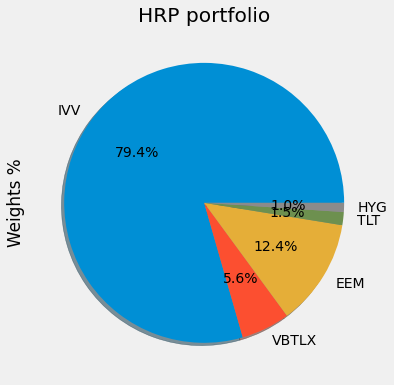

In [47]:
w = np.around(w*100, decimals=2)
w_hrp = pd.DataFrame(data = w)
w_ivp.columns =['Weights %']
w_ivp.index = assets
plot = w_ivp.plot.pie(y='Weights %', title="HRP portfolio", legend=False, autopct='%1.1f%%', 
                   shadow=True, startangle=0, figsize=(6, 6))

In [31]:
df0=corr.loc[sortIx,sortIx]
df0

,VBTLX,TLT,HYG,IVV,EEM
VBTLX,1.000000,0.887620,-0.051149,-0.251323,-0.162077
TLT,0.887620,1.000000,-0.236839,-0.376072,-0.277754
HYG,-0.051149,-0.236839,1.000000,0.772882,0.677254
IVV,-0.251323,-0.376072,0.772882,1.000000,0.786049
EEM,-0.162077,-0.277754,0.677254,0.786049,1.000000


In [34]:
def plotCorrMatrix(path,corr,labels = None):
    # Heatmap of the correlation matrix
    if labels is None:labels=[]
    mpl.pcolor(corr)
    mpl.colorbar()
    mpl.yticks(np.arange(.5,corr.shape[0]+.5),labels)
    mpl.xticks(np.arange(.5,corr.shape[0]+.5),labels)
    mpl.savefig(path)
    mpl.clf();mpl.close() # reset pylab
    return

In [35]:
import os

os.chdir("/Users/apple/Desktop/python")

plotCorrMatrix('HRP3_corr1.png',df0,labels=df0.columns)
plotCorrMatrix('HRP3_corr0.png',corr,labels=corr.columns)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/apple/Desktop/python'

MC simulation

In [37]:
import scipy.cluster.hierarchy as sch, random
import numpy as np
import pandas as pd

def generateData(nObs,sLength,size0,size1,mu0,sigma0,sigma1F):
    #Time series of correlated variables
    #1)generate random uncorrelated data
    x=np.random.normal(mu0,sigma0,size=(nObs,size0))
    #2)create correlation between the variables
    cols=[random.randint(0,size0-1) for i in range(size1)]
    y=x[:,cols]+np.random.normal(0,sigma0*sigma1F,size=(nObs,len(cols)))
    x=np.append(x,y,axis=1)
    #3)add common random shock
    point=np.random.randint(sLength,nObs-1,size=2)
    x[np.ix_(point,[cols[0],size0])]=np.array([[-.5,-.5],[2,2]])
    #4)add specific random shock
    point=np.random.randint(sLength,nObs-1,size=2)
    x[point,cols[-1]]=np.array([-.5,2])
    return x,cols
#--------------------------------------
def getHRP(cov,corr):
    # construct a hierarchical portfolio
    corr,cov=pd.DataFrame(corr),pd.DataFrame(cov)
    dist=correlDist(corr)
    link=sch.linkage(dist,'single')
    sortIx=getQuasiDiag(link)
    sortIx=corr.index[sortIx].tolist()# recover labels
    hrp=getRecBipart(cov,sortIx)
    return hrp.sort_index()


#-----------------------------------
def hrpMC(numIters=1e4,nObs=520,size0=5,size1=5,mu0=0,sigma0=1e-2,sigma1F=.25,\
          sLength=260,rebal=22):
    #Monte Carlo experiment on HRP
    methods=[getIVP,getHRP]
    stats,numIter={i.__name__:pd.Series() for i in methods},0
    pointers=range(sLength,nObs,rebal)
    while numIter<numIters:
        print(numIter)
        #1) prepare data for one experiment
        x,cols=generateData(nObs,sLength,size0,size1,mu0,sigma0,sigma1F)
        r={i.__name__:pd.Series() for i in methods}
        #2) compute portfolios in sample
        for pointer in pointers:
            x_=x[pointer-sLength:pointer]
            cov_,corr_=np.cov(x_,rowvar=0),np.corrcoef(x_,rowvar=0)
            #3) compute performance out of sample
            x_=x[pointer:pointer+rebal]
            for func in methods:
                w_=func(cov=cov_,corr=corr_)#callback
                r_=pd.Series(np.dot(x_,w_))
                r[func.__name__]=r[func.__name__].append(r_)
            #4) Evaluate and store results
            for func in methods:
                r_=r[func.__name__].reset_index(drop=True)
                p_=(1+r_).cumprod()
                stats[func.__name__].loc[numIter]=p_.iloc[-1]-1
            numIter+=1
        #5) Report results
        stats=pd.DataFrame.from_dict(stats,orient='columns')
        stats.to_csv('stats.csv')
        df0,df1=stats.std(),stats.var()
        print(pd.concat([df0,df1,df1/df1['getHRP']-1],axis=1))
        return
#-------------------------------------
if __name__=='__main__':hrpMC()


<ipython-input-37-ca1dcece4482>:37: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats,numIter={i.__name__:pd.Series() for i in methods},0
<ipython-input-37-ca1dcece4482>:43: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  r={i.__name__:pd.Series() for i in methods}


0
               0         1         2
getIVP  0.112923  0.012752  0.148322
getHRP  0.105378  0.011104  0.000000


<ipython-input-37-ca1dcece4482>:25: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link=sch.linkage(dist,'single')
<ipython-input-37-ca1dcece4482>:25: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link=sch.linkage(dist,'single')
